# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
# YOUR CODE HERE
data.iloc[190][1]

'Yeah All you self-promoters are janky We established like the Yankees This whole fuckin\' game thankless We movin\' militant but somehow you the one tankin\' No limit to where I can take it And you know me as a Cris\' bottle sender, check picker-upper I thought we looked out for one another Saw us all as brothers in the struggle, too blessed to be humble I guess it\'s different in the city I come from All the sudden I got people showing how much they truly resent me They whole demeanor just spells envy, they tryna tempt me The higher I get, the less they accept me Even had the OG\'s tryna press me, ha-ha-ha, ha No way out \'cause I\'m already in it I\'m not attending when I do a show and get a ticket Good business can clean millions, I got the vision I been had it since "No Scrubs" and "No Pigeons" Even back when I wasn\'t as poppin\' When they told me take an R&B nigga on the road And I told \'em no and drew for Kendrick and Rocky I tried to make the right choices with the world watc

In [4]:
!pip install unidecode

You should consider upgrading via the '/Users/jean-bricetonin/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
from unidecode import unidecode

In [6]:
data['verse'] = data['verse'].apply(unidecode)

In [7]:
data.head()

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [8]:
data.shape

(3975, 2)

In [9]:
# YOUR CODE HERE
data = data.drop_duplicates()

In [10]:
data.shape

(3031, 2)

In [11]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [12]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [13]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [14]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [15]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [16]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [17]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [18]:
# YOUR CODE HERE
X_words = [x.split(' ') for x in data['verse']]

In [19]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [20]:
data['seq'] = data['verse'].apply(lambda x: text_to_word_sequence(x))

<ipython-input-20-9a69fd4fdfa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data['verse'].apply(lambda x: text_to_word_sequence(x))


In [21]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

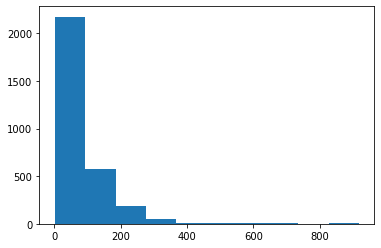

In [22]:
# YOUR CODE HERE
plt.hist([len(_) for _ in X_words])
plt.show()

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [23]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(X_words)
X_tokens = tk.texts_to_sequences(X_words)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 300
X_pad = pad_sequences(X_tokens, dtype=float, padding='post', maxlen=maxlen)

In [25]:
X_words_pad = pad_sequences(X_words, dtype=str, padding='post', maxlen=maxlen)

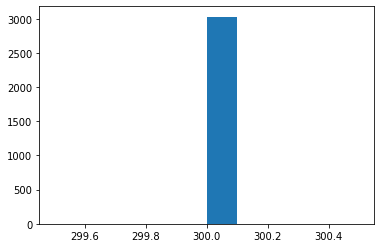

In [26]:
plt.hist([len(_) for _ in X_pad])
plt.show()

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [27]:
# YOUR CODE HERE
from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=X_words, vector_size = 100)

/Users/jean-bricetonin/.pyenv/versions/lewagon/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [28]:
def embed_sentence(word2vec, sentence):
    embed =[]
    for word in sentence:
        try:
            word_vec = word2vec.wv[word]
            embed.append(word_vec)
        except:
            next
        
    return np.array(embed)

In [29]:
data['embed'] = data['seq'].apply(lambda x: embed_sentence(word2vec, x))

<ipython-input-29-5b326c5ad045>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['embed'] = data['seq'].apply(lambda x: embed_sentence(word2vec, x))


In [30]:
data.head()

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[-0.3332435, 0.1967915, 0.37517256, 0.2990429..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-0.23250519, 0.13153179, 0.22062872, 0.20350..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[-0.06910895, 0.036777165, 0.058114003, 0.069..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[-0.25726053, 0.21310174, 0.2846657, 0.250684..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-0.23250519, 0.13153179, 0.22062872, 0.20350..."


In [31]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [32]:
data.shape

(3031, 4)

In [33]:
# YOUR CODE HERE
X = data['embed']
np.array(X).shape

(3031,)

In [34]:
X_pad = pad_sequences(X, dtype='float32', padding='post', value=0,maxlen=300)

In [35]:
X_pad.shape

(3031, 300, 100)

In [36]:
X = X_pad

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [37]:
# YOUR CODE HERE
data['artist'].value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['artist']])
y = ohe.transform(data[['artist']])

In [40]:
X.shape

(3031, 300, 100)

👉 We train/test split the dataset below for you

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2424, 300, 100), (607, 300, 100), (2424, 3), (607, 3))

In [43]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [44]:
# YOUR CODE HERE
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

! rm data_lyrics_solution.pickle

--2021-06-29 17:27:17--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.105.233
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.105.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693.81M  19.7MB/s    in 36s     

2021-06-29 17:27:53 (19.3 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]



In [45]:
score_baseline = data['artist'].value_counts()[0]/len(data)

In [46]:
score_baseline

0.45892444737710325

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [48]:
# YOUR CODE HERE
from tensorflow.keras import layers, Sequential, regularizers

reg_l2 = regularizers.L2(0.01)

model = Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(300,100)))
model.add(layers.LSTM(20, activation='tanh', kernel_regularizer=reg_l2))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 9,923
Trainable params: 9,923
Non-trainable params: 0
______________________________________________________

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [ ]:
from tensorflow.keras.optimizers import Optimizer

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [50]:
# YOUR CODE HERE
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
             metrics='accuracy')

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5,restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
          epochs=100,
          batch_size=32, 
          verbose=2,
          callbacks = [es])

Epoch 1/100
61/61 - 11s - loss: 1.8046 - accuracy: 0.4131 - val_loss: 1.6281 - val_accuracy: 0.4412
Epoch 2/100
61/61 - 6s - loss: 1.4876 - accuracy: 0.4863 - val_loss: 1.3982 - val_accuracy: 0.4680
Epoch 3/100
61/61 - 6s - loss: 1.2895 - accuracy: 0.5379 - val_loss: 1.2447 - val_accuracy: 0.5113
Epoch 4/100
61/61 - 6s - loss: 1.1350 - accuracy: 0.5781 - val_loss: 1.1220 - val_accuracy: 0.5588
Epoch 5/100
61/61 - 6s - loss: 1.0308 - accuracy: 0.6204 - val_loss: 1.0387 - val_accuracy: 0.6062
Epoch 6/100
61/61 - 6s - loss: 0.9575 - accuracy: 0.6493 - val_loss: 0.9904 - val_accuracy: 0.6144
Epoch 7/100
61/61 - 6s - loss: 0.9034 - accuracy: 0.6617 - val_loss: 0.9850 - val_accuracy: 0.6165
Epoch 8/100
61/61 - 6s - loss: 0.8793 - accuracy: 0.6746 - val_loss: 0.9470 - val_accuracy: 0.6289
Epoch 9/100
61/61 - 6s - loss: 0.8230 - accuracy: 0.6998 - val_loss: 0.9187 - val_accuracy: 0.6268
Epoch 10/100
61/61 - 6s - loss: 0.8060 - accuracy: 0.7055 - val_loss: 0.9074 - val_accuracy: 0.6289
Epoch 11

❓ **Plot the training and validation losses through training**

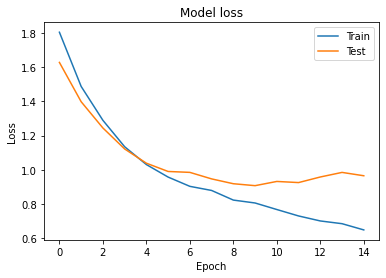

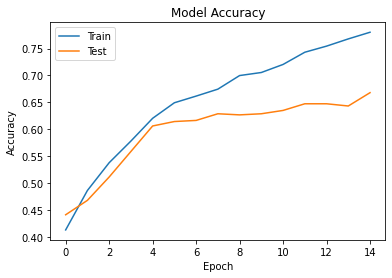

<Figure size 432x288 with 0 Axes>

In [56]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plot_loss_accuracy(history)
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [53]:
# YOUR CODE HERE
score_test = model.evaluate(X_test, y_test, verbose=0)
score_test

[0.8764358758926392, 0.6457990407943726]

🧪 **Send your results below**

In [54]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()